<a href="https://colab.research.google.com/github/EduHdzVillasana/COVIDSTATSMX/blob/master/An%C3%A1lisis%20y%20Modelado/COVID_MX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis estadístico del dataset de COVID-19 proporcionado por la secretaría de salud.

### Objetivos
* Identidicar los factores de los pacientes que aumentan su probabilidad de fallecer o presentar enfermedad grave.
* Identificar si la mortalidad varía dependiendo de la recidencia del paciente o en qué institución de salud se atendió.
* Identificar si la probabilidad de padecer la enfermedad grave varía dependiendo de la recidencia del paciente o en qué institución de salud se atendió.
* Identificar si los dias entre el inicio de los sintomas y la atención médica afecta en la mortalidad.
* Conocer si la mortalidad y la positividad cambió en el transcurso de la pandemia.
* Realizar una limpieza y tratamiento de datos para obtener un dataset listo para crear un modelo predictorio de la probabilidad de muerte de un paciente dadas sus características.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import os
import sys
import seaborn as sns

# Librerias para la regresión logística
import statsmodels.api as sm
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from tabulate import tabulate
from sklearn import linear_model

# Librerias para la validación del modelo
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Librería hecha para manejar el dataset de covid
sys.path.insert(1,'/content/drive/MyDrive/Python Scripts/')
import COVID19_MX as covid

## Carga de Dataset principal y auxiliares
Los dataset auxiliares `sexo_df`, `sector_df` y `entidad_df` servirán para usar variables categóricas en el modelo.

In [4]:
aux_dataset_path = "https://raw.githubusercontent.com/EduHdzVillasana/COVIDSTATSMX/master/Diccionario%20de%20Datos"
main_dataset_path = "/content/drive/MyDrive/Datos Abiertos"
covid_file = "210703COVID19MEXICO.csv"
sexo_file = "Sexo.csv"
sector_file = "Sector.csv"
entidad_file = "Entidad.csv"

In [5]:
covid_df = pd.read_csv(os.path.join(main_dataset_path,covid_file))
sexo_df = pd.read_csv(os.path.join(aux_dataset_path,sexo_file))
sector_df = pd.read_csv(os.path.join(aux_dataset_path,sector_file))
entidad_df = pd.read_csv(os.path.join(aux_dataset_path,entidad_file))

## Limpieza y Tratamiento de Datos

In [6]:
covid_df.sample(2)

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
5250666,2021-07-03,480704,2,4,9,1,9,9,17,2,2021-02-22,2021-02-10,9999-99-99,2,2,29,1,2,2,2,2,2,2,2,2,1,2,2,2,1,2,1,2,1,2,7,99,México,97,2
5335197,2021-07-03,9aaea3,2,12,9,2,9,9,17,1,2021-02-23,2021-02-23,9999-99-99,97,2,92,1,97,2,2,2,2,2,2,2,2,2,2,2,2,1,1,2,2,97,7,99,México,97,97


In [7]:
covid_df.dtypes

FECHA_ACTUALIZACION      object
ID_REGISTRO              object
ORIGEN                    int64
SECTOR                    int64
ENTIDAD_UM                int64
SEXO                      int64
ENTIDAD_NAC               int64
ENTIDAD_RES               int64
MUNICIPIO_RES             int64
TIPO_PACIENTE             int64
FECHA_INGRESO            object
FECHA_SINTOMAS           object
FECHA_DEF                object
INTUBADO                  int64
NEUMONIA                  int64
EDAD                      int64
NACIONALIDAD              int64
EMBARAZO                  int64
HABLA_LENGUA_INDIG        int64
INDIGENA                  int64
DIABETES                  int64
EPOC                      int64
ASMA                      int64
INMUSUPR                  int64
HIPERTENSION              int64
OTRA_COM                  int64
CARDIOVASCULAR            int64
OBESIDAD                  int64
RENAL_CRONICA             int64
TABAQUISMO                int64
OTRO_CASO                 int64
TOMA_MUE

In [8]:
covid_df.shape

(7573379, 40)

### Se agrega columna Resultado
**Se agrega la columna de `RESULTADO` para facilitar el análisis** 
* Positivo: 1
* Negativo: 2
* Sospechoso: 3

In [9]:
covid_df["RESULTADO"] = covid_df["CLASIFICACION_FINAL"].apply(covid.getResult)

In [10]:
covid_df[["CLASIFICACION_FINAL","RESULTADO"]].sample(10)

,CLASIFICACION_FINAL,RESULTADO
1598289,7,2
86740,6,3
533249,7,2
4540319,5,3
5847442,7,2
4395743,7,2
5972756,7,2
7103316,7,2
6790428,3,1
2045934,7,2


In [11]:
date = "2021-07-03"
comulative_cases = covid.getComulativeCases(covid_df)
covid.printCumulativeCases(comulative_cases, date)

Fecha de actualización: 2021-07-03

  Total de casos estudiados: 7573379

  Casos Positivos a SARS-CoV-2: 2537457

  Casos No Positivos a SARS-CoV-2: 4593408

  Casos Con Resultado Pendiente: 442514

  Defunciones Positivas a SARS-CoV-2: 233580

  Tasa de Letalidad: 9.205%

  Tasa de Positividad : 35.584%



### Filtrado de casos con datos incompletos

En el diccionario de datos se identifico que hay valores *no aplica* o *no especificado*, para realizar el análisis hay que eliminar esos valores, ya sea eliminando el caso que los contenga o cambiandolo. El problema es que esos valores están en varias columnas, por lo tanto se tendrá que usar un `for loop`.

In [12]:
# Se filtra el dataset para eliminar casos con información No especificada y se toman solamente los casos positivos.
data_filtered = covid_df[(covid_df["SEXO"] != 99)
& (covid_df["SECTOR"] != 99)
& (covid_df["ENTIDAD_UM"] < 97)
& (covid_df["RESULTADO"] == 1)]

In [13]:
# Se filtran los datos No especificados de las categorias SI-NO (leer el diccionario de datos)
data_filtered["EMBARAZO"] = np.where(data_filtered["SEXO"] == 2, 2, data_filtered["EMBARAZO"])

categorias_si_no = ['INTUBADO','UCI','NEUMONIA','DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
                    'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO','EMBARAZO']

for cat in categorias_si_no:
  data_filtered = data_filtered[data_filtered[cat] <= 97]
  data_filtered[cat] = data_filtered[cat].apply(lambda x: 1 if x == 1 else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
# Se eliminan los datos no especificados de la columna TIPO_PACIENTE
data_filtered = data_filtered[data_filtered["TIPO_PACIENTE"] != 99]

In [15]:
data_filtered.shape

(2510966, 41)

Oficialmente hay 2,244,268 casos positivos a SARS-COV-2, pero después del filtrado obtuvimos 2,221,525, hay una diferencia de 22,743 casos, esto se debe a que se eliminaron casos con información incompleta. Por la cantidad de datos esta diferencia es estadísticamente insignificante y no supondrá un problema en el análisis o en la creación del modelo.

In [16]:
data_filtered.sample(5)

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI,RESULTADO
2372533,2021-07-03,1f7936,1,4,3,1,12,3,8,1,2020-10-29,2020-10-26,9999-99-99,0,0,32,1,0,2,2,0,0,1,0,1,0,0,0,0,0,2,1,1,2,97,3,99,México,97,0,1
4175155,2021-07-03,693072,2,4,13,2,13,13,61,1,2021-01-04,2021-01-02,9999-99-99,0,0,39,1,0,2,2,0,0,0,0,0,0,0,0,0,0,2,2,97,1,1,3,99,México,97,0,1
5246090,2021-07-03,d63595,2,4,9,1,9,9,15,1,2021-02-19,2021-02-17,9999-99-99,0,0,59,1,0,2,2,0,0,0,0,0,0,0,0,0,0,1,2,97,1,1,3,99,México,97,0,1
1192564,2021-07-03,1cb03e,2,5,20,1,20,20,513,1,2020-08-03,2020-07-29,9999-99-99,0,0,42,1,0,2,2,0,0,0,0,0,0,0,0,0,0,1,1,1,2,97,3,99,México,97,0,1
2821869,2021-07-03,1f783a,2,12,9,2,9,9,5,1,2020-11-27,2020-11-27,9999-99-99,0,0,31,1,0,2,2,0,0,0,0,0,0,0,0,0,0,2,2,97,1,1,3,99,México,97,0,1


### Cambio de tipo de dato de fechas
**Las columnas de `FECHA_SINTOMAS` y `FECHA_INGRESO` correspondientes a la fecha de inicio de sintomas y a la fecha de ingreso a la unidad de atención estan en string, se les cambiará a tipo de dato `datetima` para el manejo de fechas**

In [17]:
data_filtered["FECHA_INGRESO"] = pd.to_datetime(data_filtered["FECHA_INGRESO"], format = "%Y-%m-%d")

In [18]:
data_filtered["FECHA_SINTOMAS"] = pd.to_datetime(data_filtered["FECHA_SINTOMAS"], format = "%Y-%m-%d")

In [19]:
data_filtered[["FECHA_INGRESO","FECHA_SINTOMAS"]].dtypes

FECHA_INGRESO     datetime64[ns]
FECHA_SINTOMAS    datetime64[ns]
dtype: object

In [20]:
data_filtered[["FECHA_INGRESO","FECHA_SINTOMAS"]].sample(5)

,FECHA_INGRESO,FECHA_SINTOMAS
885932,2020-07-13,2020-07-07
4087831,2020-12-25,2020-12-23
941635,2020-07-06,2020-07-05
5838777,2021-03-18,2021-03-16
3870068,2021-01-04,2020-12-28


### Agregado de columna `TIEMPO_ESPERA`
Se agrega la columna `TIEMPO_ESPERA` que indica el tiempo en días que paso desde el inicio de los sintomas `FECHA_SINTOMAS` y el ingreso a la unidad de salud `FECHA_INGRESO`.

In [21]:
data_filtered["TIEMPO_ESPERA"] = data_filtered["FECHA_INGRESO"] - data_filtered["FECHA_SINTOMAS"]
data_filtered["TIEMPO_ESPERA"] = data_filtered["TIEMPO_ESPERA"].apply(lambda x: x.days)

In [22]:
data_filtered["TIEMPO_ESPERA"].dtypes

dtype('int64')

### Agregado de columna `FALLECIDO`
Esta columna será catagórica, indica si el paciente falleció por covid, los valores posibles son los siguientes:
* Si: *1*
* No: *0*

In [23]:
data_filtered["FALLECIDO"] = data_filtered["FECHA_DEF"].apply(lambda x: 1 if x != "9999-99-99" else 0)

In [24]:
data_filtered[["FECHA_DEF","FALLECIDO"]].sample(10)

,FECHA_DEF,FALLECIDO
3208474,9999-99-99,0
2201727,9999-99-99,0
2872317,9999-99-99,0
3554971,9999-99-99,0
3695465,9999-99-99,0
5059815,9999-99-99,0
2702042,9999-99-99,0
3886630,9999-99-99,0
7482997,9999-99-99,0
724358,9999-99-99,0


### Agregado de la columna `ENFERMEDAD_GRAVE`
Esta columna será catagórica, indica si el paciente presentó enfermedad grave.

Se considera que un paciente presentó la enfermedad grave si presenta al menos una de las siguientes situaciones:
* El paciente requirió de intubación.
* El paciente fue diagnosticado con neumonía.
* El paciente requirió ingresar a una Unidad de Cuidados Intensivos.

Los valores posibles en esta columna son los siguientes:
* Si: *1*
* No: *0*

In [25]:
data_filtered["ENFERMEDAD_GRAVE"] = np.where((data_filtered["INTUBADO"] == 1) 
| (data_filtered["NEUMONIA"] == 1)
| (data_filtered["UCI"] == 1) , 1, 0)

In [26]:
data_filtered[["NEUMONIA", "INTUBADO", "UCI", "ENFERMEDAD_GRAVE"]].sample(10)

,NEUMONIA,INTUBADO,UCI,ENFERMEDAD_GRAVE
1659709,0,0,0,0
4012900,0,0,0,0
863070,0,0,0,0
2224578,0,0,0,0
3649852,0,0,0,0
2158136,0,0,0,0
4100442,1,0,0,1
4655422,0,0,0,0
2810116,0,0,0,0
1739159,0,0,0,0


### Agregado de columna `HOSPITALIZADO`
Esta columna será catagórica, indica si el paciente fue hospitalizado, si esto no es así se asume que el tratamiento del paciente fue embulatorio, los valores posibles son los siguientes:
* Si: *1*
* No: *0*

In [27]:
data_filtered["HOSPITALIZADO"] = data_filtered["TIPO_PACIENTE"].apply(lambda x: 1 if x == 2 else 0)

In [28]:
data_filtered[["TIPO_PACIENTE", "HOSPITALIZADO"]].sample(10)

,TIPO_PACIENTE,HOSPITALIZADO
4093145,1,0
5312757,1,0
6658072,1,0
6670495,1,0
6396901,1,0
2534767,1,0
5451473,1,0
5730103,2,1
5515523,2,1
4189324,1,0



### Combinación del dataframe principal con los dataframes auxiliares.

In [29]:
# Se le cambian los nombres de las columnas a los dataframes auxiliares
sexo_df.columns = ["SEXO", "SEXO_"]
sector_df.columns = ["SECTOR", "SECTOR_ATENDIDO"]
entidad_df.columns = ["ENTIDAD_UM","ESTADO"]

In [30]:
data_filtered = pd.merge(data_filtered, sexo_df, how = "inner", on = "SEXO")
data_filtered = pd.merge(data_filtered, sector_df, how = "inner", on = "SECTOR")
data_filtered = pd.merge(data_filtered, entidad_df, how = "inner", on = "ENTIDAD_UM")

In [31]:
data_filtered[["SEXO_","SECTOR_ATENDIDO","ESTADO"]].sample(5)

,SEXO_,SECTOR_ATENDIDO,ESTADO
1482688,HOMBRE,IMSS,MC
2421602,MUJER,SSA,MS
578897,MUJER,SSA,DF
1497211,HOMBRE,IMSS,MC
1181632,MUJER,ESTATAL,TC


## Análisis Exploratorio

En esta sección se obtendrán algunos datos estadísticos que pueden ayudar a comprender el comportamiento de la enfermedad.

In [32]:
# Para esta sección se definio una función para obtener los cartiles
def summary(data):
  minimo = data.min()
  Q1 = data.quantile(0.25)
  median = data.median()
  mean = data.mean()
  Q2 = data.quantile(0.5)
  Q3 = data.quantile(0.75)
  maximo = data.max()
  IQR = Q3 - Q1
  resumen = {'minimo': minimo, 'Q1': Q1, 'mediana':median,'Q2':Q2,'Q3':Q3,'max':maximo,'IQR':IQR, 'media':mean}
  return resumen

### Distribución de edad por sexo de los infectados.

Text(0, 0.5, 'Número de casos confirmados')

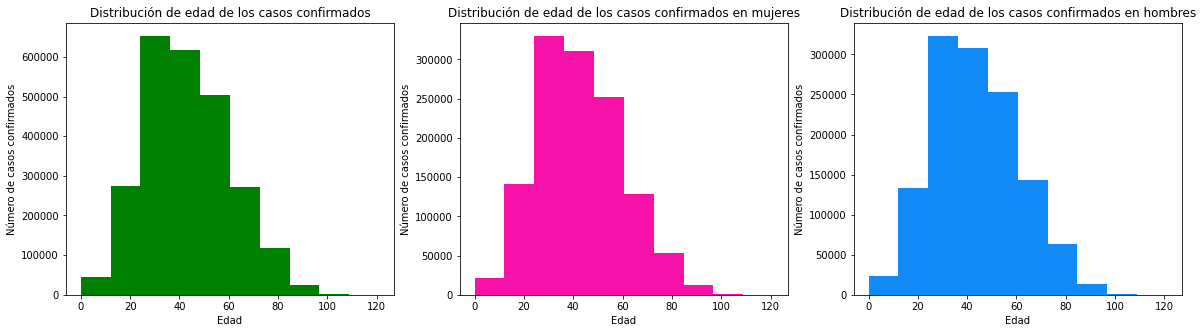

In [33]:
fig, axs = plt.subplots(ncols = 3, nrows = 1)
fig.set_size_inches(20,5)

axs[0].hist(data_filtered["EDAD"], color="g")
axs[0].set_title("Distribución de edad de los casos confirmados")
axs[0].set_xlabel("Edad")
axs[0].set_ylabel("Número de casos confirmados")

axs[1].hist(data_filtered["EDAD"][data_filtered["SEXO_"] == "MUJER"], color="#F611A9")
axs[1].set_title("Distribución de edad de los casos confirmados en mujeres")
axs[1].set_xlabel("Edad")
axs[1].set_ylabel("Número de casos confirmados")

axs[2].hist(data_filtered["EDAD"][data_filtered["SEXO_"] == "HOMBRE"], color="#1189F6")
axs[2].set_title("Distribución de edad de los casos confirmados en hombres")
axs[2].set_xlabel("Edad")
axs[2].set_ylabel("Número de casos confirmados")


In [34]:
print("Resumen edad de casos positivos")
age_summary = summary(data_filtered["EDAD"])
age_summary

Resumen edad de casos positivos


{'IQR': 25.0,
 'Q1': 30.0,
 'Q2': 42.0,
 'Q3': 55.0,
 'max': 121,
 'media': 43.300010553711424,
 'mediana': 42.0,
 'minimo': 0}

**Se puede ver que la distribución varía poco entre hombres y mujeres, el 50% de los contagios están entre los 31 y 55 años de edad**

### Distribución de edad en casos hospitalizados y ambulatorios.

Text(0, 0.5, 'Número de casos confirmados')

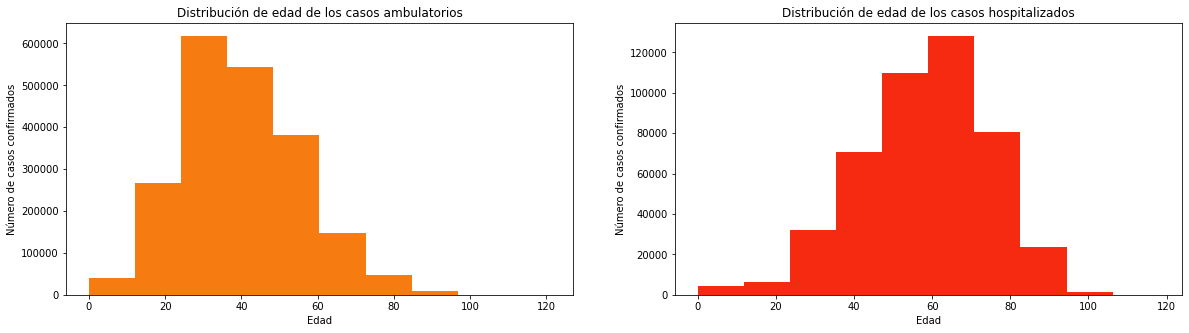

In [35]:
fig, axs = plt.subplots(ncols=2,nrows=1)
fig.set_size_inches(20,5)

axs[0].hist(data_filtered["EDAD"][data_filtered["HOSPITALIZADO"] == 0], color="#F67C11")
axs[0].set_title("Distribución de edad de los casos ambulatorios")
axs[0].set_xlabel("Edad")
axs[0].set_ylabel("Número de casos confirmados")

axs[1].hist(data_filtered["EDAD"][data_filtered["HOSPITALIZADO"] == 1], color="#F62911")
axs[1].set_title("Distribución de edad de los casos hospitalizados")
axs[1].set_xlabel("Edad")
axs[1].set_ylabel("Número de casos confirmados")

In [36]:
print("Resumen edad de casos ambulatorios")
amb_age = summary(data_filtered["EDAD"][data_filtered["HOSPITALIZADO"] == 0])
amb_age

Resumen edad de casos ambulatorios


{'IQR': 21.0,
 'Q1': 29.0,
 'Q2': 39.0,
 'Q3': 50.0,
 'max': 121,
 'media': 40.04837977728329,
 'mediana': 39.0,
 'minimo': 0}

In [37]:
print("Resumen edad de casos hospitalizados")
amb_age = summary(data_filtered["EDAD"][data_filtered["HOSPITALIZADO"] == 1])
amb_age

Resumen edad de casos hospitalizados


{'IQR': 22.0,
 'Q1': 48.0,
 'Q2': 59.0,
 'Q3': 70.0,
 'max': 118,
 'media': 57.905129747285315,
 'mediana': 59.0,
 'minimo': 0}

**Se puede apreciar que el grueso de los casos tratados ambulatoriamente están entre los 29 y 51 años de edad mientras que los hospitalizados estan entre los 48 y 70.**

### Distribución por edad de fallecidos

Text(0, 0.5, 'Número de casos confirmados')

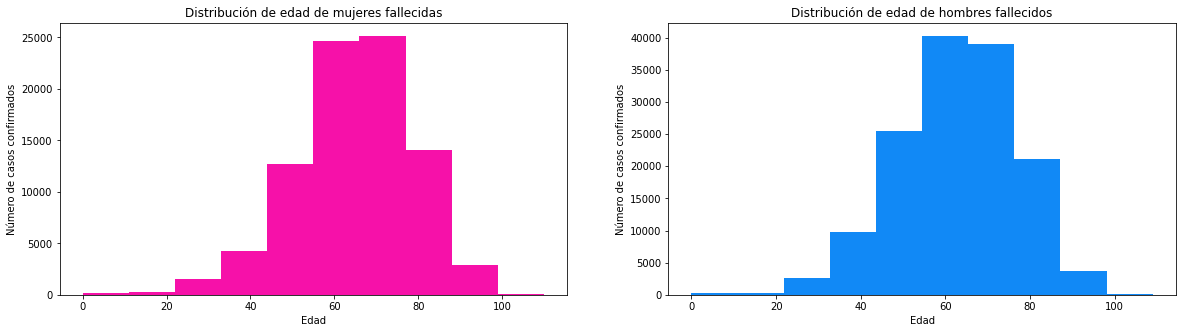

In [38]:
fig, axs = plt.subplots(ncols=2,nrows=1)
fig.set_size_inches(20,5)

axs[0].hist(data_filtered["EDAD"][(data_filtered["SEXO_"] == "MUJER")&(data_filtered["FALLECIDO"] == 1)], color="#F611A9")
axs[0].set_title("Distribución de edad de mujeres fallecidas")
axs[0].set_xlabel("Edad")
axs[0].set_ylabel("Número de casos confirmados")

axs[1].hist(data_filtered["EDAD"][(data_filtered["SEXO_"] == "HOMBRE")&(data_filtered["FALLECIDO"] == 1)], color="#1189F6")
axs[1].set_title("Distribución de edad de hombres fallecidos")
axs[1].set_xlabel("Edad")
axs[1].set_ylabel("Número de casos confirmados")

In [39]:
print("Resumen edad en mujeres fallecidas")
female_deceased = summary(data_filtered["EDAD"][(data_filtered["SEXO_"] == "MUJER")&(data_filtered["FALLECIDO"] == 1)])
female_deceased

Resumen edad en mujeres fallecidas


{'IQR': 18.0,
 'Q1': 56.0,
 'Q2': 65.0,
 'Q3': 74.0,
 'max': 110,
 'media': 64.40453282268047,
 'mediana': 65.0,
 'minimo': 0}

In [40]:
print("Resumen edad en hombres fallecidos")
male_deceased = summary(data_filtered["EDAD"][(data_filtered["SEXO_"] == "HOMBRE")&(data_filtered["FALLECIDO"] == 1)])
male_deceased

Resumen edad en hombres fallecidos


{'IQR': 19.0,
 'Q1': 54.0,
 'Q2': 64.0,
 'Q3': 73.0,
 'max': 109,
 'media': 62.83373214974913,
 'mediana': 64.0,
 'minimo': 0}

**El 50% de los fallecidos parece estar entre los 55 y 74 años de edad**

### Comparación de mortalidad en hombres y mujeres

In [41]:
table = pd.crosstab(data_filtered.SEXO_, data_filtered.FALLECIDO)
table["MORTALIDAD"] = table[1]/(table[0]+table[1])
table

FALLECIDO,0,1,MORTALIDAD
SEXO_,,,
HOMBRE,1118113,142505,0.113044
MUJER,1164705,85642,0.068495


Text(0, 0.5, 'Porcentaje de fallecidos (%)')

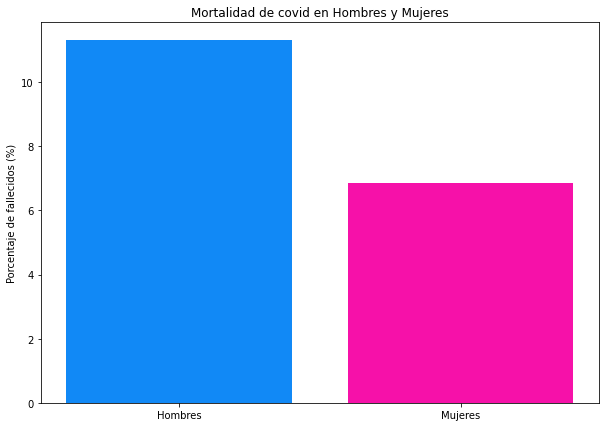

In [42]:
plt.figure(figsize = (10,7))
plt.bar(["Hombres"], table["MORTALIDAD"][0]*100, color = "#1189F6")
plt.bar(["Mujeres"], table["MORTALIDAD"][1]*100, color = "#F611A9")
plt.title("Mortalidad de covid en Hombres y Mujeres")
plt.ylabel("Porcentaje de fallecidos (%)")

## Mortalidad por estado y por sector

### Mortalidad por estado


In [43]:
table = pd.crosstab(data_filtered.ESTADO, data_filtered.FALLECIDO)
table["MORTALIDAD"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["MORTALIDAD"])
table

FALLECIDO,0,1,MORTALIDAD
ESTADO,,,
BS,38771,1539,0.038179
TC,73192,3569,0.046495
DF,748712,44013,0.055521
QT,65666,4592,0.065359
DG,30915,2264,0.068236
NL,118087,9797,0.076608
OC,44337,3795,0.078846
SR,72434,6418,0.081393
TS,60647,5378,0.081454


Text(0, 0.5, 'Porcentaje de fallecidos (%)')

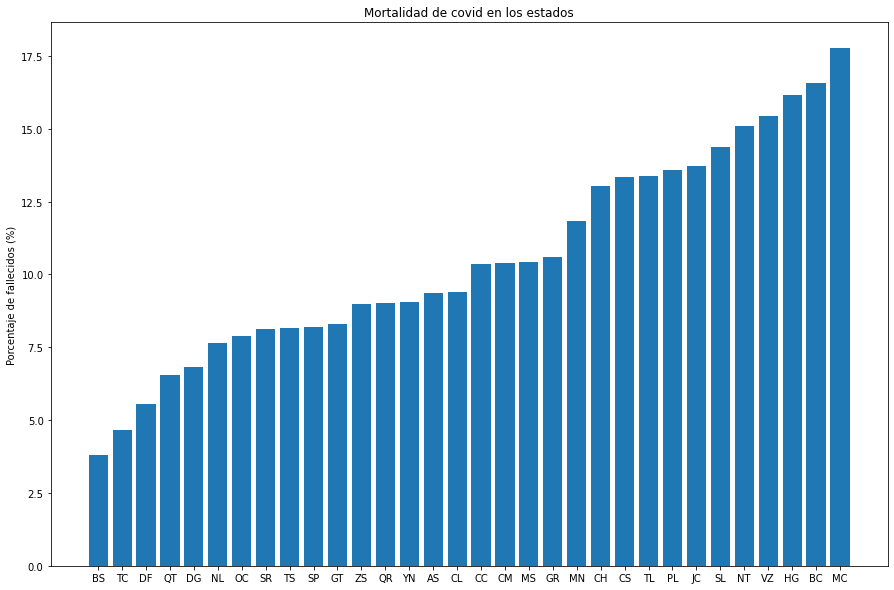

In [44]:
plt.figure(figsize = (15,10))
plt.bar(table.index,table["MORTALIDAD"]*100)
plt.title("Mortalidad de covid en los estados")
plt.ylabel("Porcentaje de fallecidos (%)")

### Mortalidad por sector de la salud

In [45]:
table = pd.crosstab(data_filtered.SECTOR_ATENDIDO, data_filtered.FALLECIDO)
table["MORTALIDAD"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["MORTALIDAD"])
table

FALLECIDO,0,1,MORTALIDAD
SECTOR_ATENDIDO,,,
DIF,834,1,0.001198
MUNICIPAL,2192,99,0.043213
SSA,1354025,62466,0.044099
PRIVADA,69074,4237,0.057795
SEMAR,7703,808,0.094936
CRUZ ROJA,221,25,0.101626
ESTATAL,26787,3335,0.110716
IMSS-BIENESTAR,12727,1845,0.126613
IMSS,709402,131819,0.156700


Text(0, 0.5, 'Porcentaje de fallecidos (%)')

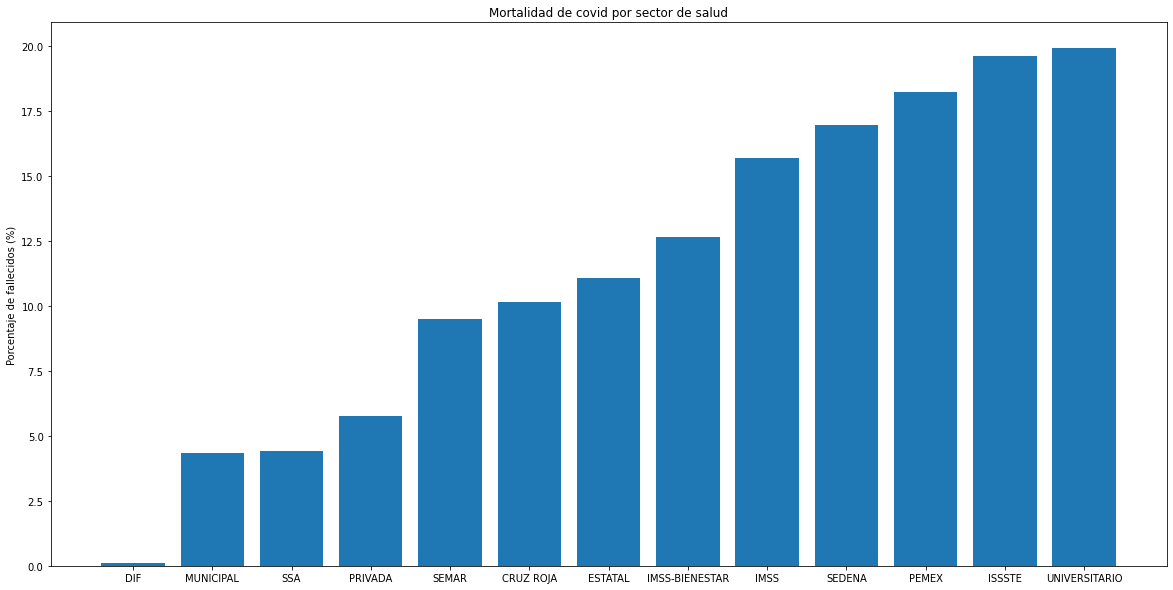

In [46]:
plt.figure(figsize = (20,10))
plt.bar(table.index,table["MORTALIDAD"]*100)
plt.title("Mortalidad de covid por sector de salud")
plt.ylabel("Porcentaje de fallecidos (%)")

## Proporcion de enfermos grave de covid por estado y por sector

### Proporción de enfermos graves por estado

In [47]:
table = pd.crosstab(data_filtered.ESTADO, data_filtered.ENFERMEDAD_GRAVE)
table["PROPORCION"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["PROPORCION"])
table

ENFERMEDAD_GRAVE,0,1,PROPORCION
ESTADO,,,
DG,31031,2148,0.064740
BS,37447,2863,0.071025
TC,70029,6732,0.087701
DF,716418,76307,0.096259
TS,59610,6415,0.097160
ZS,27911,3112,0.100313
CL,61431,6892,0.100874
YN,42531,5258,0.110025
OC,42570,5562,0.115557


Text(0, 0.5, 'Porcentaje de enfermos (%)')

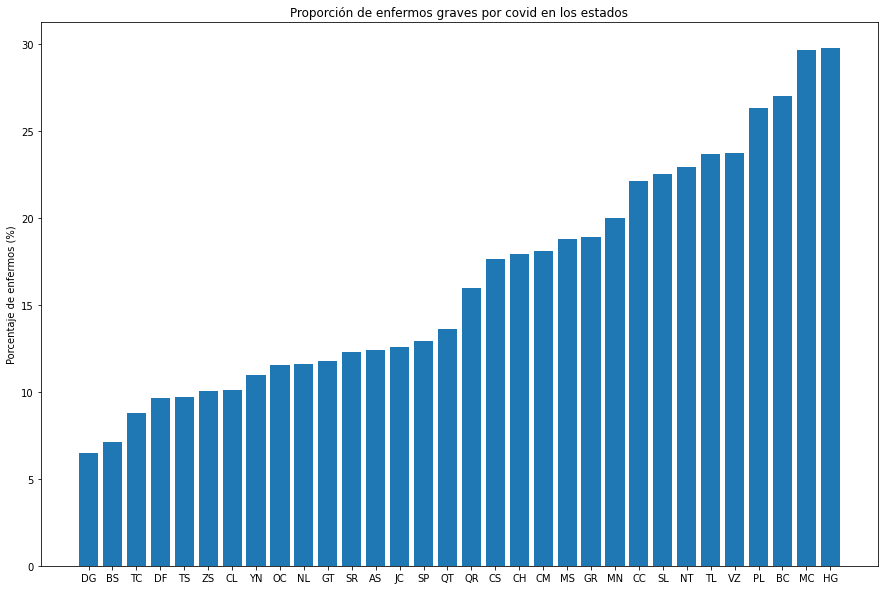

In [48]:
plt.figure(figsize = (15,10))
plt.bar(table.index,table["PROPORCION"]*100)
plt.title("Proporción de enfermos graves por covid en los estados")
plt.ylabel("Porcentaje de enfermos (%)")

### Proporción de enfermos graves por sector de salud

In [49]:
table = pd.crosstab(data_filtered.SECTOR_ATENDIDO, data_filtered.ENFERMEDAD_GRAVE)
table["PROPORCION"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["PROPORCION"])
table

ENFERMEDAD_GRAVE,0,1,PROPORCION
SECTOR_ATENDIDO,,,
DIF,809,26,0.031138
SSA,1287038,129453,0.091390
MUNICIPAL,2058,233,0.101702
CRUZ ROJA,214,32,0.130081
IMSS,684823,156398,0.185918
PRIVADA,57672,15639,0.213324
IMSS-BIENESTAR,11277,3295,0.226119
SEMAR,6458,2053,0.241217
SEDENA,12717,4094,0.243531


Text(0, 0.5, 'Porcentaje de enfermos graves (%)')

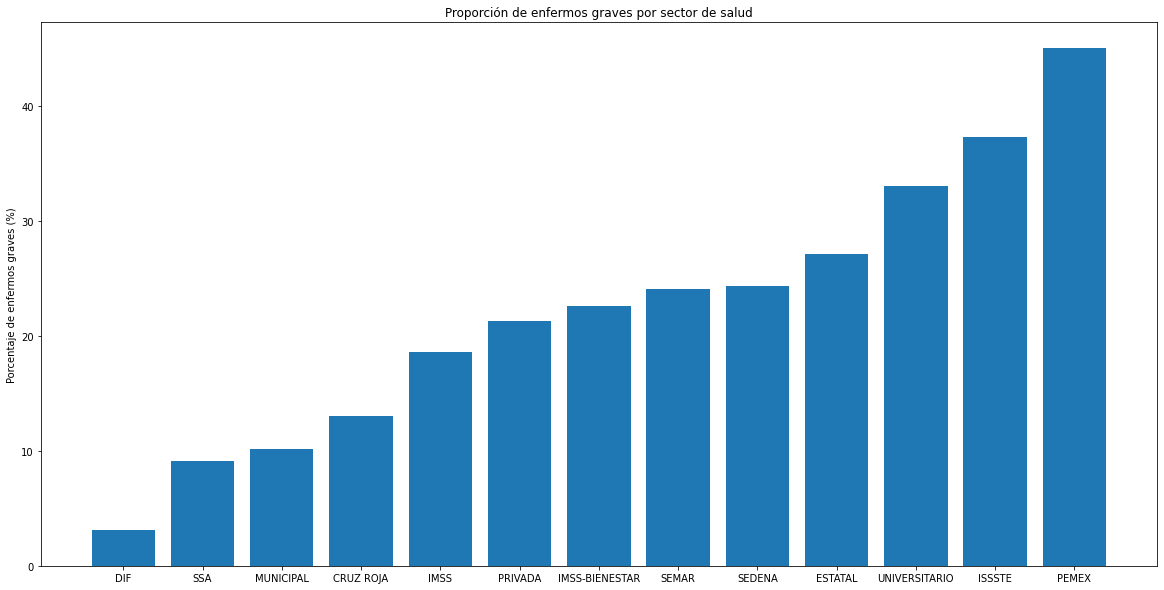

In [50]:
plt.figure(figsize = (20,10))
plt.bar(table.index,table["PROPORCION"]*100)
plt.title("Proporción de enfermos graves por sector de salud")
plt.ylabel("Porcentaje de enfermos graves (%)")

## Mortalidad por días de espera
Se obtendrá la mortalidad según los días entre que el paciente presento síntomas y cuando se atendió en una unidad de salud.

Text(0.5, 0, 'Dias pasados entre el inicio de los sintomas e ingreso a una institucion de salud')

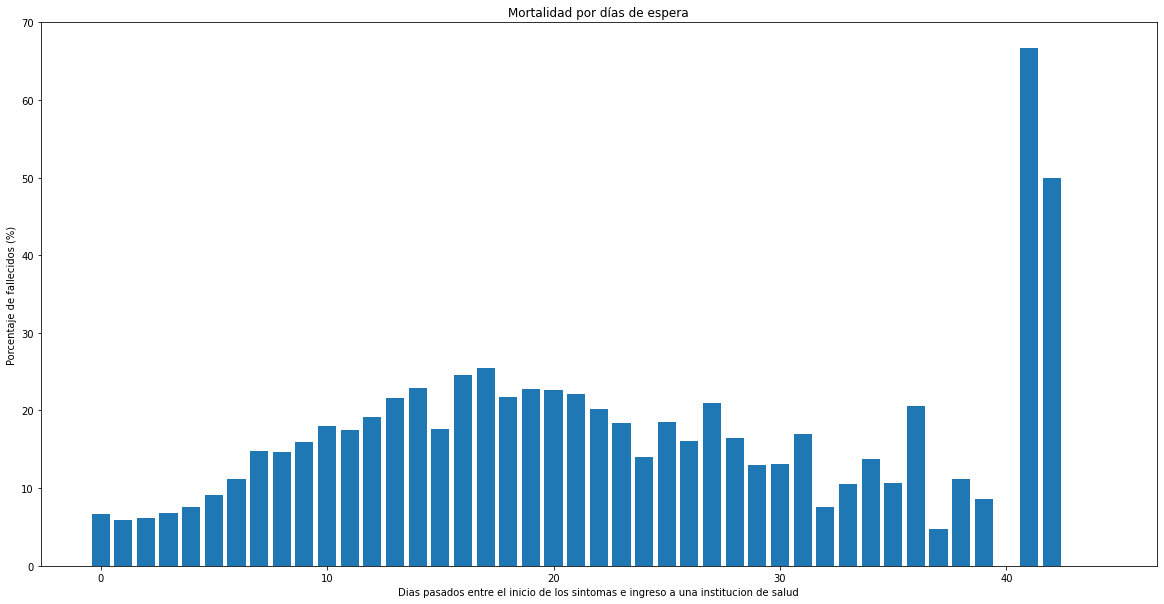

In [51]:
table = pd.crosstab(data_filtered.TIEMPO_ESPERA, data_filtered.FALLECIDO)
table["MORTALIDAD"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["TIEMPO_ESPERA"])
table = table[0:45]

plt.figure(figsize = (20,10))
plt.bar(table.index,table["MORTALIDAD"]*100)
plt.title("Mortalidad por días de espera")
plt.ylabel("Porcentaje de fallecidos (%)")
plt.xlabel("Dias pasados entre el inicio de los sintomas e ingreso a una institucion de salud")

Se puede ver que aumenta la mortalidad entre más días de espera.

##  Mortalidad y Positividad a lo largo de la pandemia
Se obtendrá la mortalidad y positividad por semana desde la primera semana del 2020 (Se registraban solamente casos sospechosos los primeros meses del 2020)

In [52]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(covid_df, dates)
cases_by_day = pd.DataFrame(cases_by_day)

### Gráfica de casos


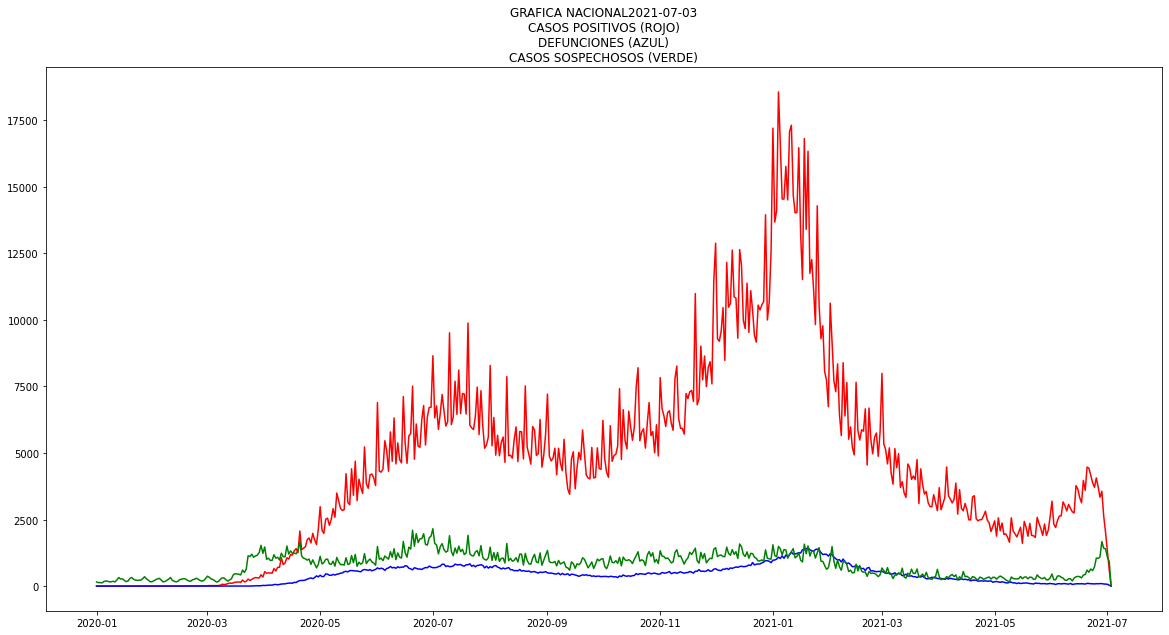

In [53]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL"+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

### Separación de semanas

In [54]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [55]:
cases_by_day.sample(10)

,FECHA,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,SEMANA
448,2021-03-24,3457,13767,339,318,64
403,2021-02-07,5653,11569,594,905,57
49,2020-02-19,2,138,226,0,7
305,2020-11-01,7831,9321,1328,455,43
504,2021-05-19,1872,10792,273,110,72
52,2020-02-22,3,168,243,0,7
462,2021-04-07,3269,14203,395,294,66
517,2021-06-01,3190,11785,452,88,73
353,2020-12-19,9529,13685,1047,792,50
45,2020-02-15,1,178,246,0,6


In [56]:
cases_by_day.tail(3)

,FECHA,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,SEMANA
547,2021-07-01,1300,3941,1092,70,78
548,2021-07-02,597,1871,926,31,78
549,2021-07-03,1,4,7,0,78


In [57]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()
cases_by_week.sample(5)

,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES
SEMANA,,,,
48,69633,103173,8335,4344
61,32576,105167,3192,3308
31,38969,45285,7702,4740
41,44807,59382,7176,2816
37,32899,48104,6099,2836


### Mortalidad

In [58]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]
cases_by_week.head(10)

,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,MORTALIDAD
SEMANA,,,,,
0,8,963,1086,0,0.000000
1,7,1278,1476,0,0.000000
2,6,1508,1712,1,0.166667
3,6,1419,1793,0,0.000000
4,5,1226,1557,0,0.000000
5,5,1393,1570,1,0.200000
6,6,1242,1572,0,0.000000
7,13,1208,1655,0,0.000000
8,63,1490,1862,1,0.015873


In [59]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])
cases_by_week.head()

,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,MORTALIDAD,DIA
SEMANA,,,,,,
0,8,963,1086,0,0.000000,2020-01-01
1,7,1278,1476,0,0.000000,2020-01-08
2,6,1508,1712,1,0.166667,2020-01-15
3,6,1419,1793,0,0.000000,2020-01-22
4,5,1226,1557,0,0.000000,2020-01-29


In [60]:
cases_by_week.tail()

,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,MORTALIDAD,DIA
SEMANA,,,,,,
74,18456,66604,2100,589,0.031914,2021-06-02
75,21769,74605,1975,567,0.026046,2021-06-09
76,27072,80265,3271,620,0.022902,2021-06-16
77,24918,71248,7590,609,0.024440,2021-06-23
78,3917,12490,3425,175,0.044677,2021-06-30


Text(0, 0.5, 'Mortalidad en porcentaje (%)')

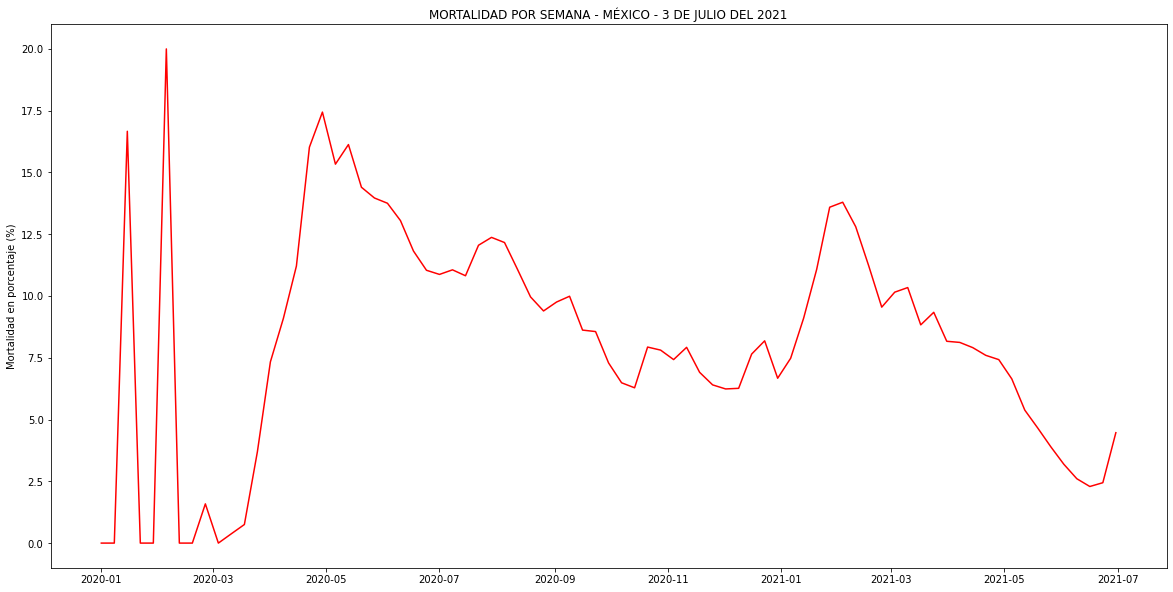

In [64]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

Se puede apreciar que los maximos de la mortalidad coinciden con los picos de las olas que han habido en México.


### Positividad

In [62]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

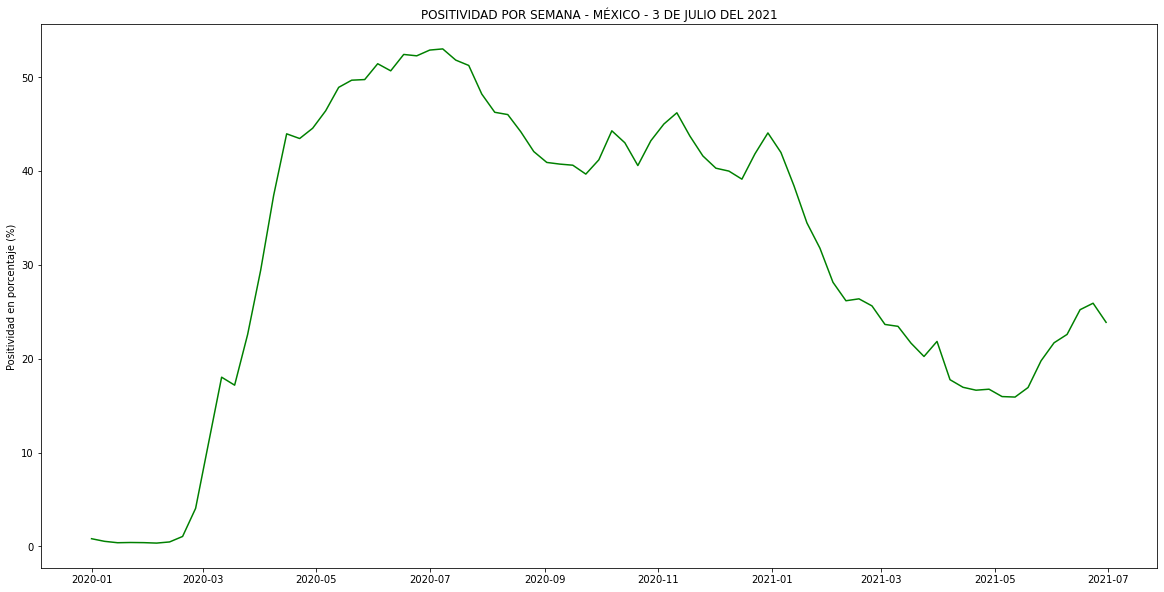

In [65]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

Al igual que con la mortalidad, la positividad cambió durante la pandemia de covid y sus puntos más altos coinciden con los picos de las olas de la epidemia que han habido.

## Guardado Dataset
Se guarda el dataset después de ser limpiado y con datos procesados

In [ ]:
dataset_file = "210401COVID19MEXICO_filtered.csv"
data_filtered.to_csv(os.path.join(main_dataset_path, dataset_file))

## Efecto de las vacunas en los grupos de población

In [68]:
data_filtered.sample(5)

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI,RESULTADO,TIEMPO_ESPERA,FALLECIDO,ENFERMEDAD_GRAVE,HOSPITALIZADO,SEXO_,SECTOR_ATENDIDO,ESTADO
1699068,2021-07-03,102fcc,2,12,2,2,16,2,4,1,2020-07-15,2020-07-12,9999-99-99,0,0,35,1,0,99,99,0,0,0,0,1,0,0,0,0,0,2,1,1,2,97,3,99,México,97,0,1,3,0,0,0,HOMBRE,SSA,BC
808480,2021-07-03,07d692,2,12,12,1,12,12,1,1,2020-07-05,2020-07-02,9999-99-99,0,0,45,1,0,2,2,0,0,0,0,0,0,0,0,0,0,2,1,1,2,97,3,99,México,97,0,1,3,0,0,0,MUJER,SSA,GR
2092463,2021-07-03,2ab1c5,1,12,5,1,5,5,18,1,2021-01-14,2021-01-04,9999-99-99,0,0,23,1,0,2,2,0,0,0,0,0,0,0,0,0,0,1,1,1,2,97,3,99,México,97,0,1,10,0,0,0,MUJER,SSA,CL
426366,2021-07-03,44bf99,1,12,9,1,9,9,13,1,2020-12-17,2020-12-17,9999-99-99,0,0,36,1,0,2,2,0,0,0,0,0,0,0,0,0,0,1,1,1,2,97,3,99,México,97,0,1,0,0,0,0,MUJER,SSA,DF
1016505,2021-07-03,1a5b79,1,12,31,2,31,31,96,1,2020-07-29,2020-07-27,9999-99-99,0,0,27,1,0,1,1,0,0,1,0,0,0,0,0,0,0,2,1,1,2,97,3,99,México,97,0,1,2,0,0,0,HOMBRE,SSA,YN


In [67]:
data_filtered.shape

(2510965, 48)

Se separará el dataframe `data_filtered` en 6 grupos:
* Mayores de 60 años
* Entre 50 y 59 años
* Entre 40 y 49 años
* Entre 30 y 39 años
* Entre 20 y 29 años
* Menores de 20 años

In [98]:
data_by_age = {}

In [99]:
data_by_age[">60"] = covid_df[covid_df["EDAD"] >= 60].copy()

In [100]:
data_by_age["50-59"] = covid_df[(covid_df["EDAD"] >= 50) & (covid_df["EDAD"] <= 59)].copy()

In [101]:
data_by_age["40-49"] = covid_df[(covid_df["EDAD"] >= 40) & (covid_df["EDAD"] <= 49)].copy()

In [102]:
data_by_age["30-39"] = covid_df[(covid_df["EDAD"] >= 30) & (covid_df["EDAD"] <= 39)].copy()

In [103]:
data_by_age["20-29"] = covid_df[(covid_df["EDAD"] >= 20) & (covid_df["EDAD"] <= 29)].copy()

In [104]:
data_by_age["<20"] = covid_df[covid_df["EDAD"] <= 19].copy()

In [105]:
keys = data_by_age.keys()
for key in keys:
  print(f"GRUPO EDAD {key}")
  comulative_cases = covid.getComulativeCases(data_by_age[key])
  covid.printCumulativeCases(comulative_cases, date)

GRUPO EDAD >60
Fecha de actualización: 2021-07-03

  Total de casos estudiados: 1046109

  Casos Positivos a SARS-CoV-2: 456340

  Casos No Positivos a SARS-CoV-2: 531984

  Casos Con Resultado Pendiente: 57785

  Defunciones Positivas a SARS-CoV-2: 147114

  Tasa de Letalidad: 32.238%

  Tasa de Positividad : 46.173%

GRUPO EDAD 50-59
Fecha de actualización: 2021-07-03

  Total de casos estudiados: 1137853

  Casos Positivos a SARS-CoV-2: 424802

  Casos No Positivos a SARS-CoV-2: 650686

  Casos Con Resultado Pendiente: 62365

  Defunciones Positivas a SARS-CoV-2: 48731

  Tasa de Letalidad: 11.471%

  Tasa de Positividad : 39.499%

GRUPO EDAD 40-49
Fecha de actualización: 2021-07-03

  Total de casos estudiados: 1489566

  Casos Positivos a SARS-CoV-2: 515677

  Casos No Positivos a SARS-CoV-2: 886599

  Casos Con Resultado Pendiente: 87290

  Defunciones Positivas a SARS-CoV-2: 25184

  Tasa de Letalidad: 4.884%

  Tasa de Positividad : 36.774%

GRUPO EDAD 30-39
Fecha de actualizac

In [115]:
table_age = pd.crosstab(data_filtered.EDAD,data_filtered.FALLECIDO)
table_age["MORTALIDAD"] = table_age[1]/(table_age[0]+table_age[1])*100
table_age = table_age.sort_values(by = ["EDAD"])

In [116]:
table_age["MORTALIDAD"].values

array([ 5.66037736,  3.21637427,  1.23343993,  0.85918854,  0.72267389,
        0.43754972,  0.52410901,  0.44628626,  0.47406581,  0.35079514,
        0.47961631,  0.26158445,  0.36306235,  0.28097063,  0.21252796,
        0.30421143,  0.34192311,  0.42620819,  0.27533685,  0.30952907,
        0.41511595,  0.42247304,  0.40582814,  0.40863267,  0.48960415,
        0.4617441 ,  0.63381876,  0.61818182,  0.73994446,  0.81090715,
        1.00182943,  1.06613983,  1.20398283,  1.27923098,  1.512546  ,
        1.71863629,  1.85317044,  2.00070789,  2.32641307,  2.58215057,
        2.88612604,  3.25838838,  3.69156041,  3.99895714,  4.58123269,
        5.08279982,  5.45629674,  5.91687878,  6.19336794,  6.79356939,
        7.45961582,  8.31882458,  9.12096038,  9.87960096, 10.77900064,
       11.82218117, 13.36743772, 13.8366726 , 14.98867389, 16.53091238,
       18.15454977, 20.42322835, 22.08487549, 23.51333625, 24.80779088,
       27.10519893, 27.52890792, 29.09852867, 31.38158533, 32.31

Text(0.5, 1.0, 'LETALIDAD POR EDAD')

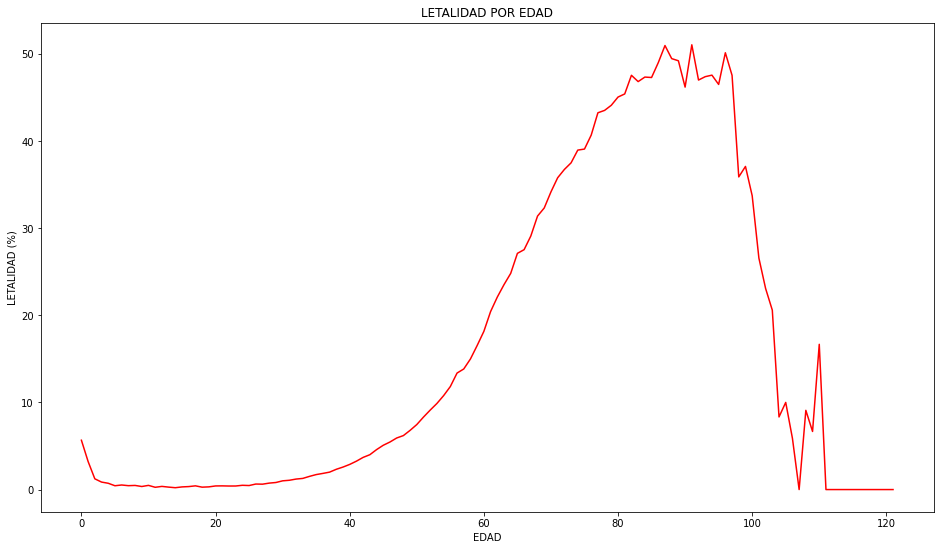

In [117]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

sns.lineplot(x = table_age.index, y = table_age["MORTALIDAD"].values, ax = ax, color = "red")
ax.set_ylabel("LETALIDAD (%)")
ax.set_title("LETALIDAD POR EDAD")

### Graficas de casos, mortalidad y positividad por grúpos de edad
Se espera ver una disminución de la mortalidad y casos en los grupos de edad que ya han sido vacunados

#### Mayores de 60 años

In [118]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age[">60"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

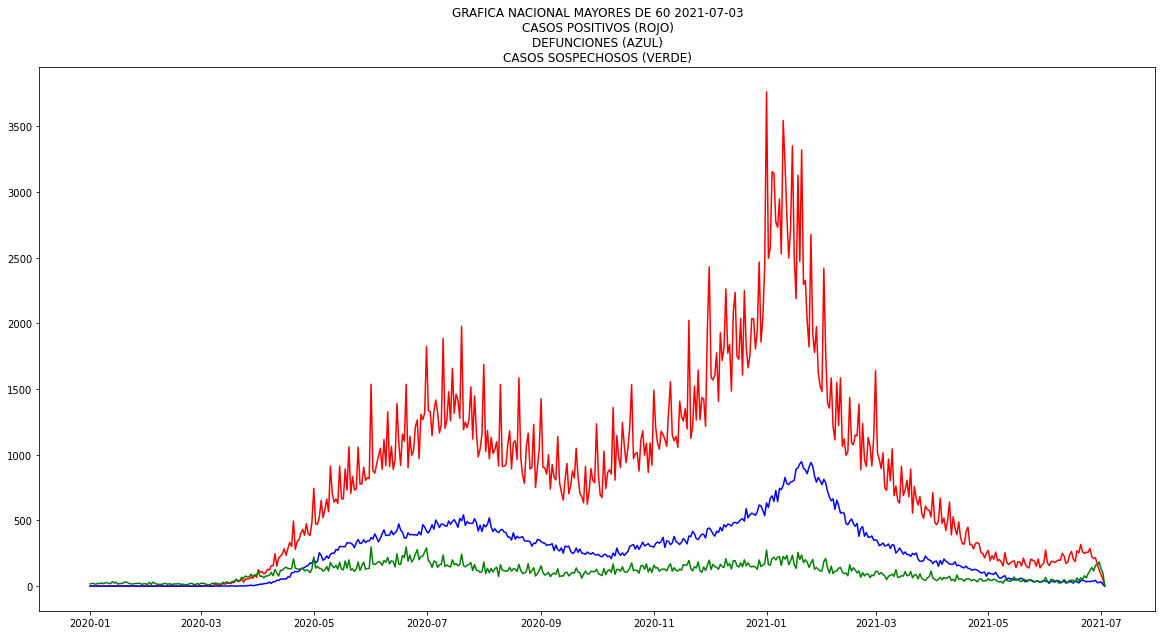

In [120]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL MAYORES DE 60 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [121]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [122]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [123]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [124]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

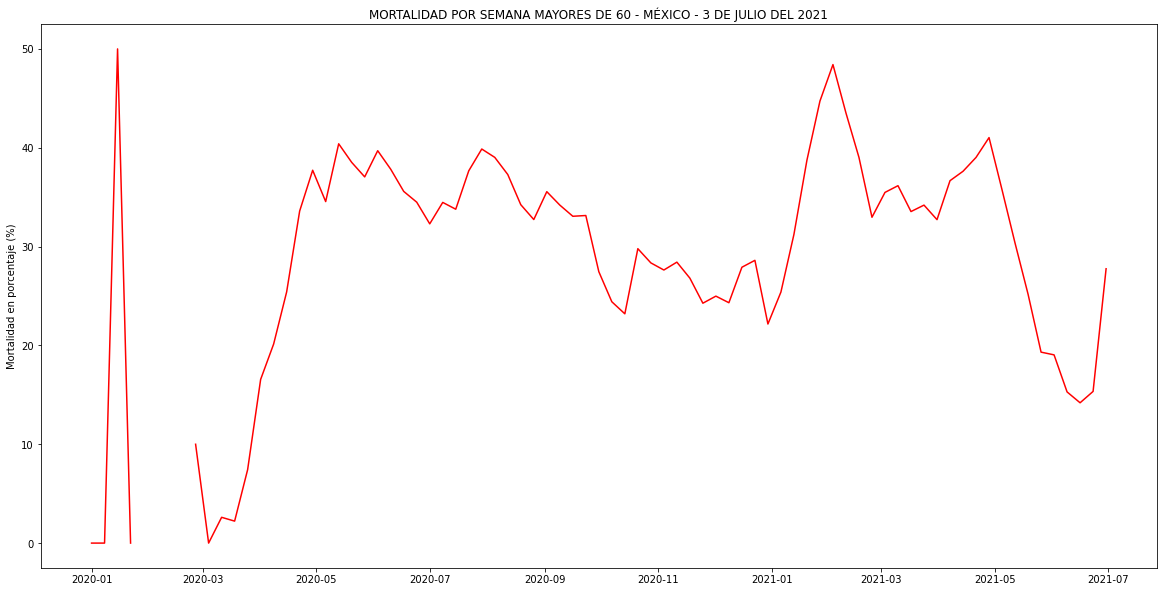

In [125]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA MAYORES DE 60 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [126]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

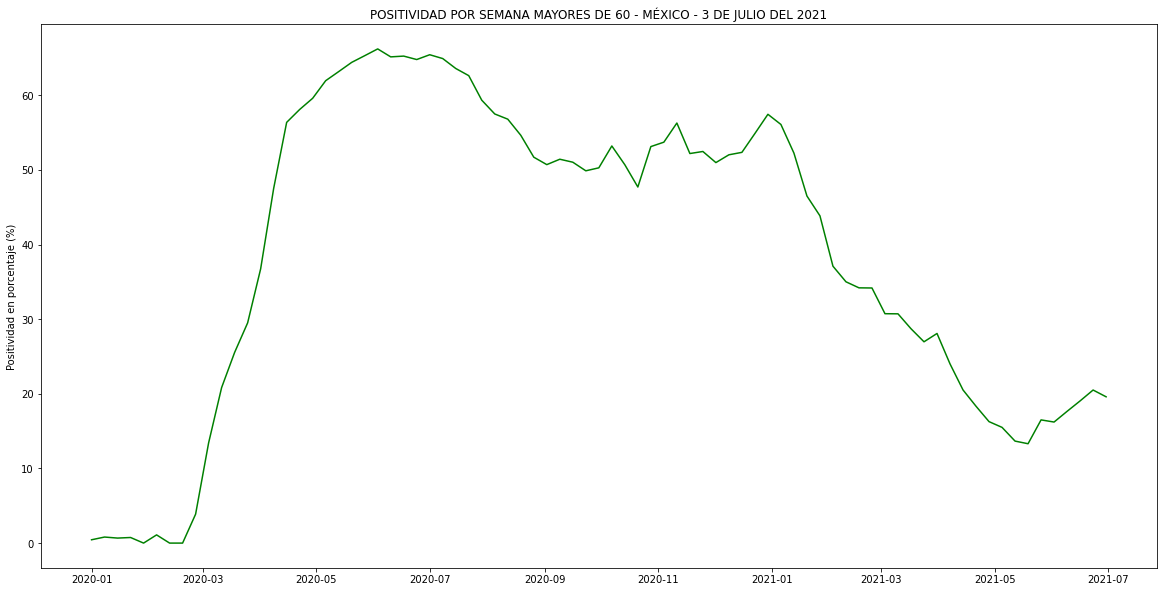

In [128]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA MAYORES DE 60 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

#### Entre 50 y 59 años

In [129]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age["50-59"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

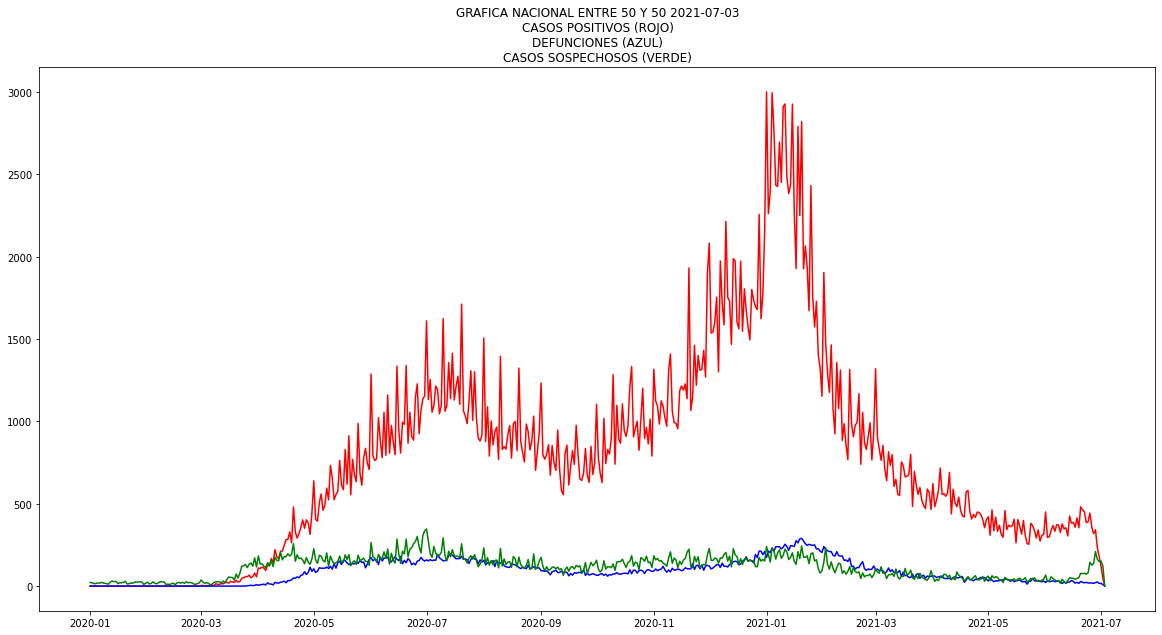

In [130]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL ENTRE 50 Y 50 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [131]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [132]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [133]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [134]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

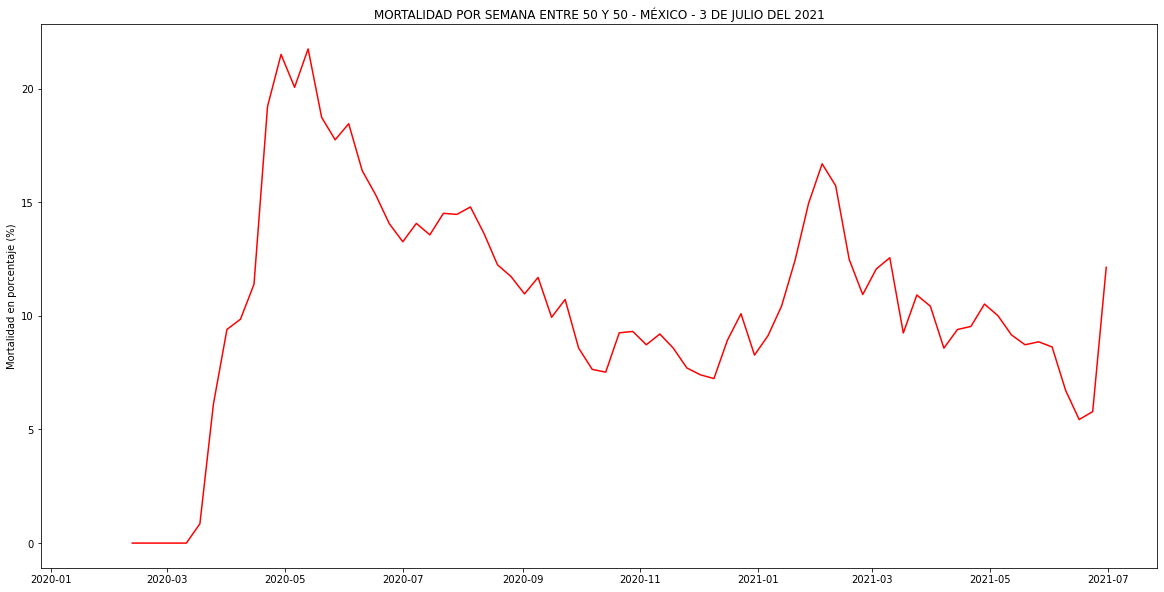

In [135]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA ENTRE 50 Y 50 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [136]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

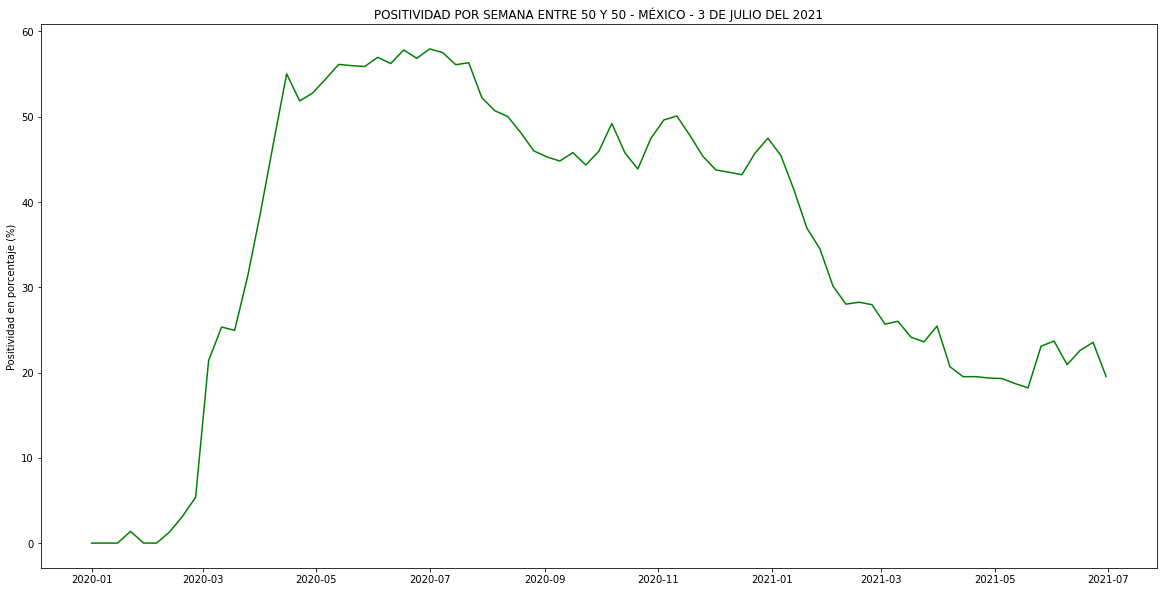

In [137]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA ENTRE 50 Y 50 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

#### Entre 40 y 49 años

In [138]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age["40-49"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

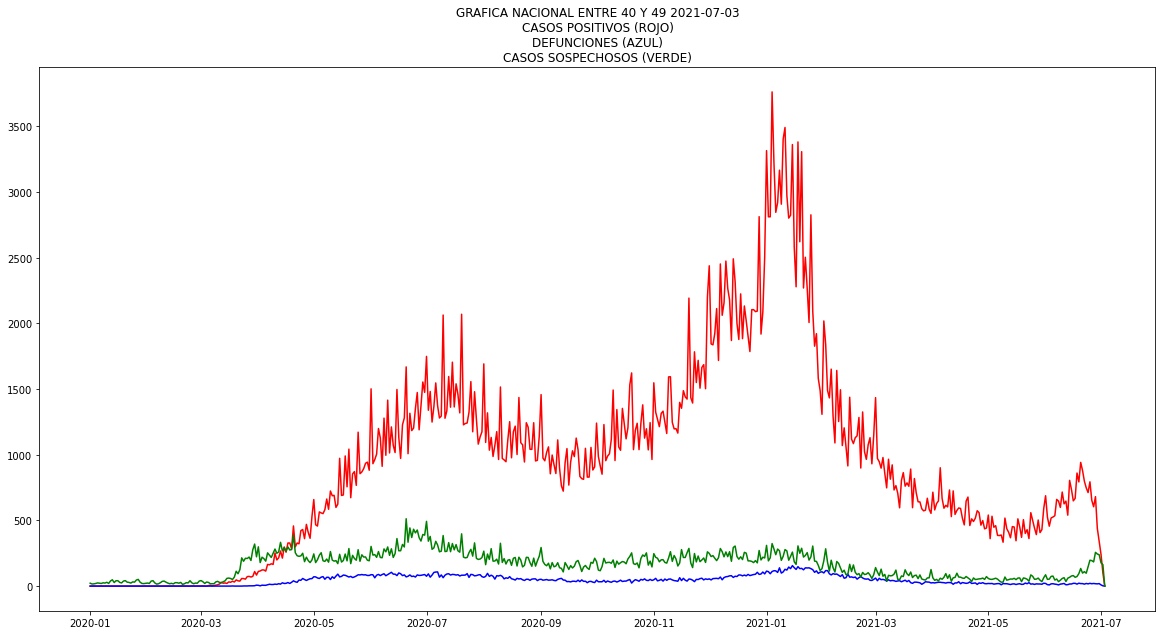

In [139]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL ENTRE 40 Y 49 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [140]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [141]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [142]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [143]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

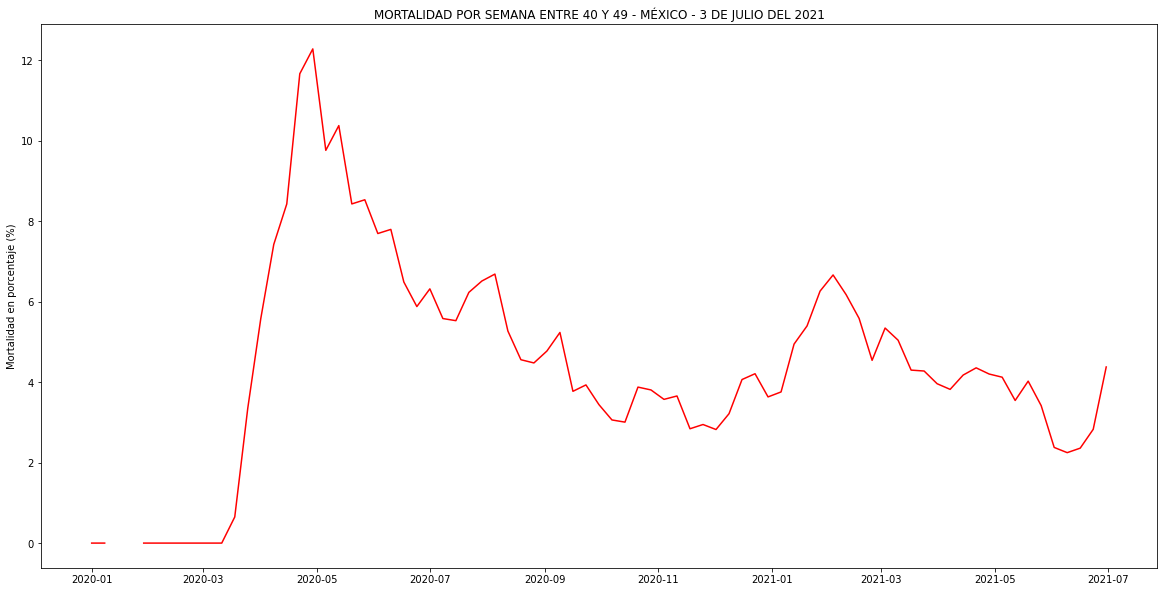

In [144]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA ENTRE 40 Y 49 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [145]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

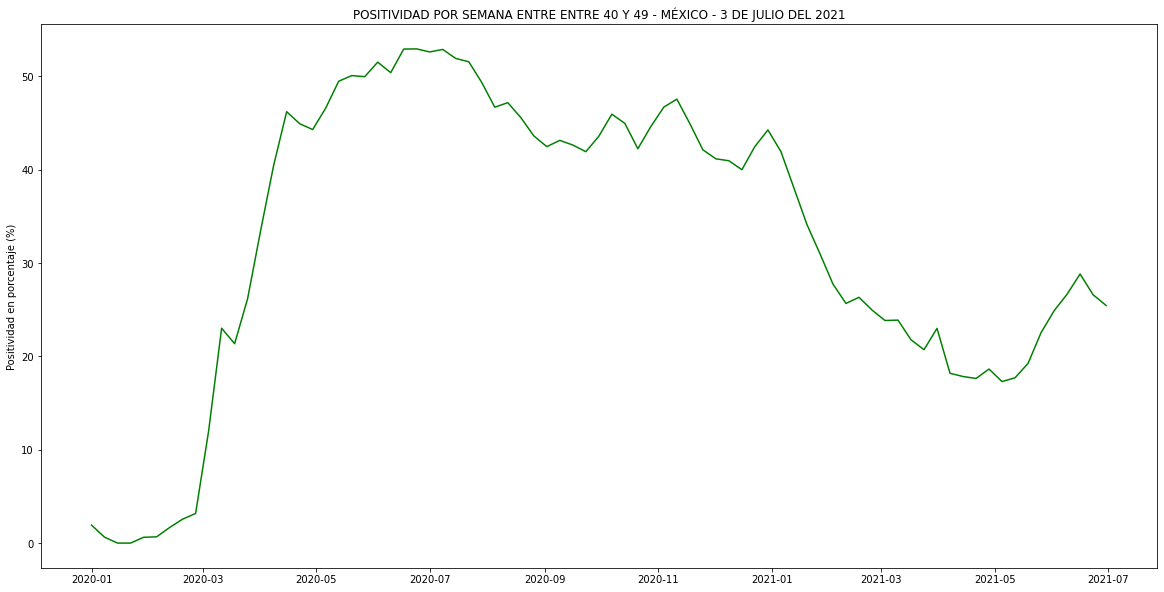

In [146]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA ENTRE ENTRE 40 Y 49 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

#### Entre 30 y 39 años

In [147]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age["30-39"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

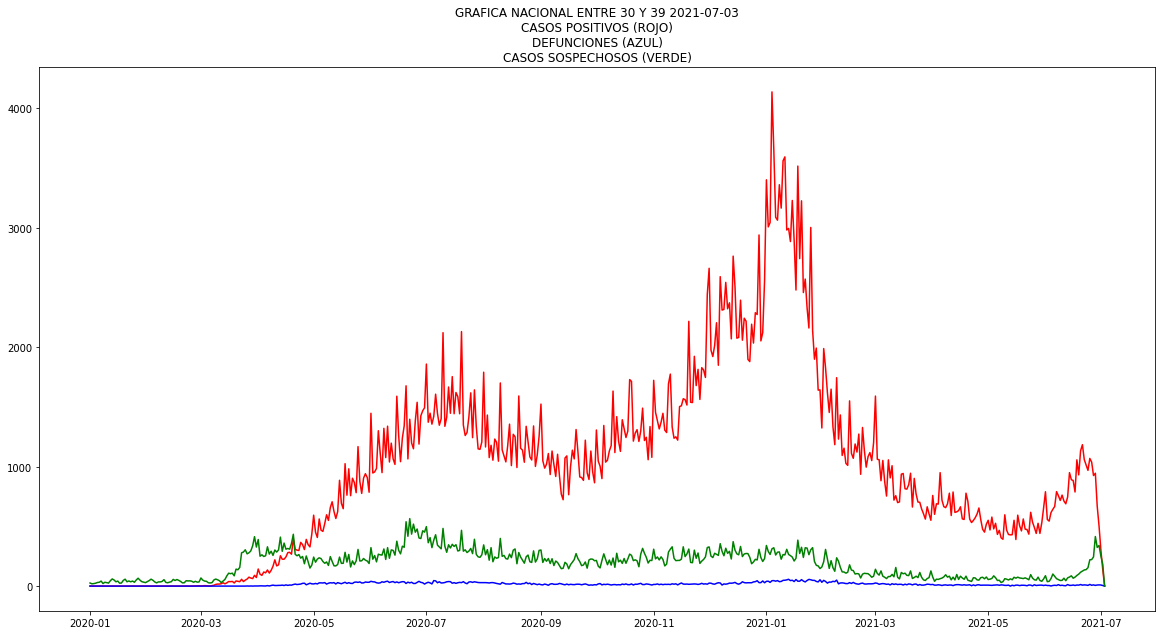

In [148]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL ENTRE 30 Y 39 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [149]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [150]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [151]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [152]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

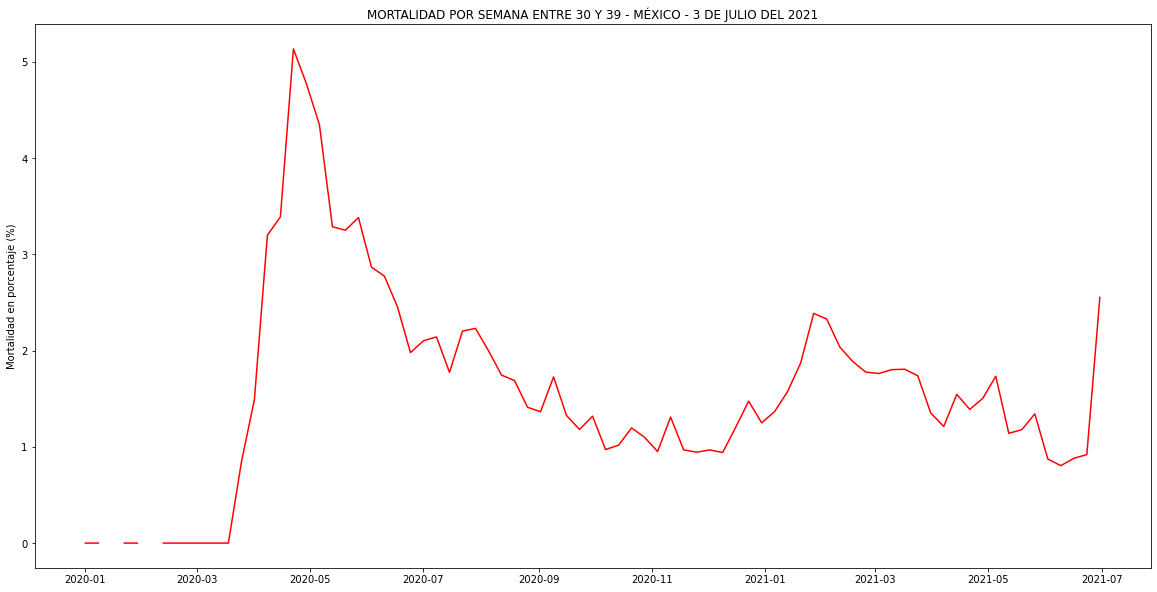

In [154]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA ENTRE 30 Y 39 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [155]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

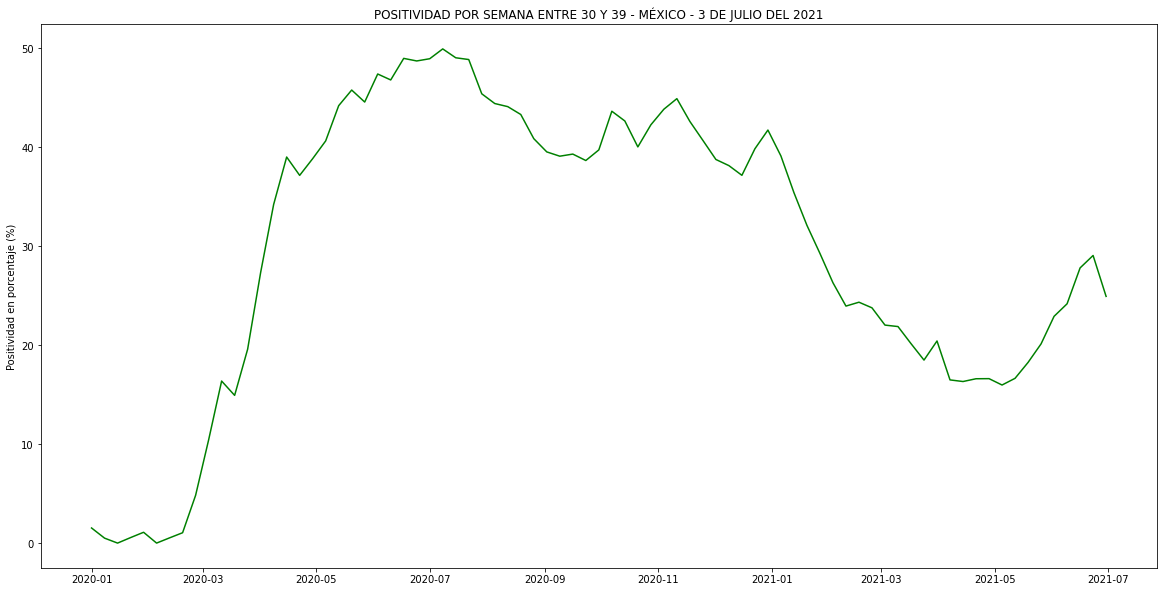

In [156]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA ENTRE 30 Y 39 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

#### Entre 20 y 29 años

In [157]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age["20-29"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

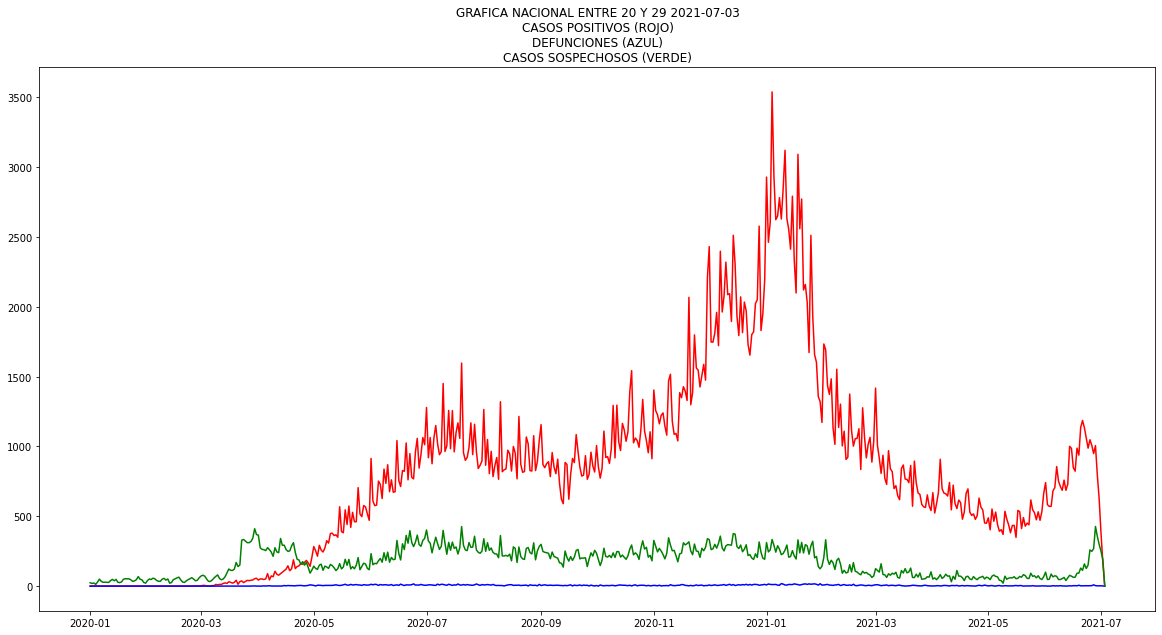

In [158]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL ENTRE 20 Y 29 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [159]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [160]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [161]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [162]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

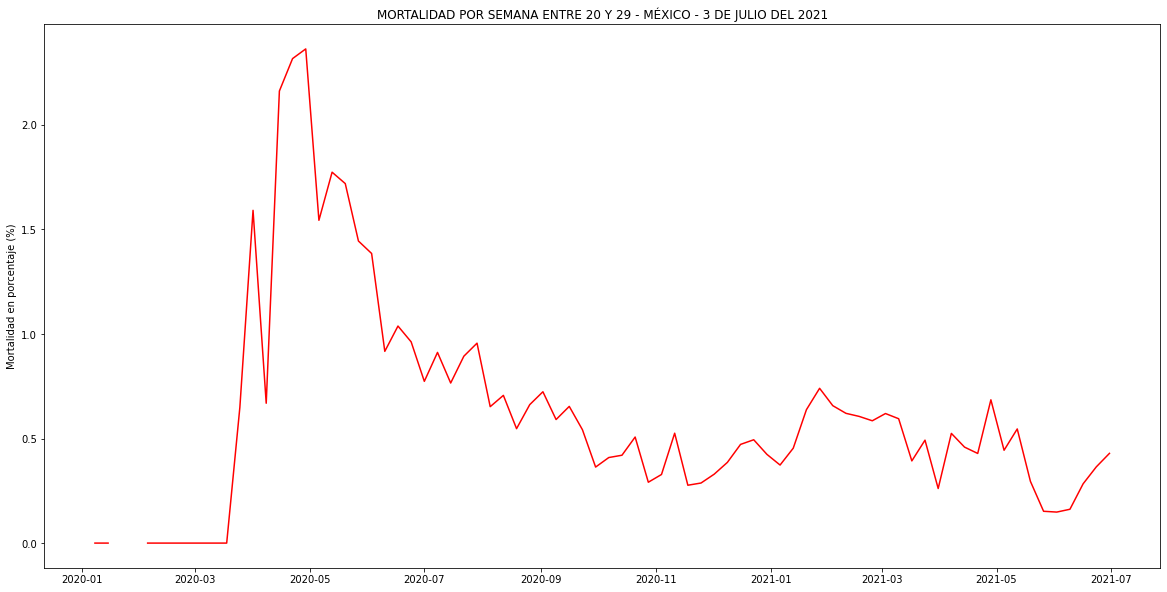

In [163]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA ENTRE 20 Y 29 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [164]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

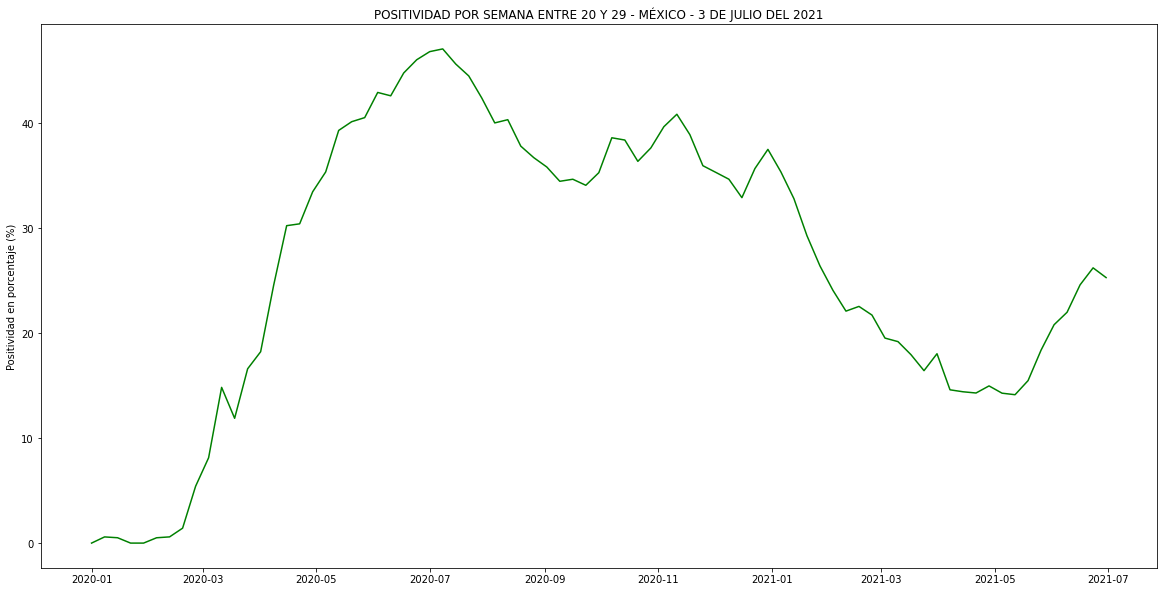

In [165]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA ENTRE 20 Y 29 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

#### Menores de 20 años

In [166]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age["<20"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

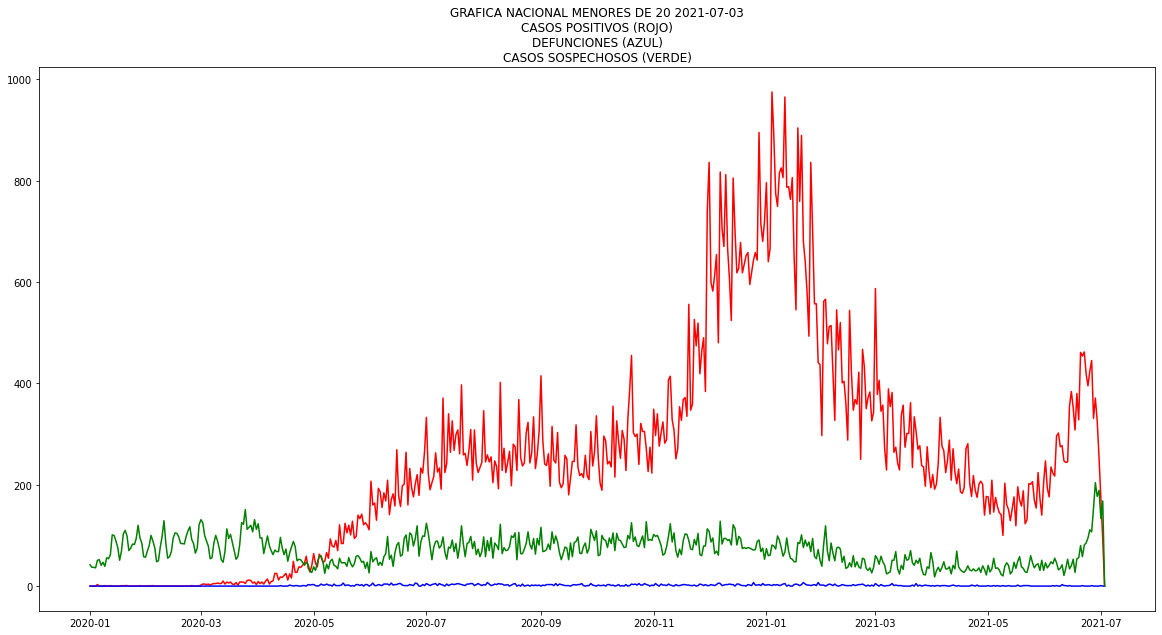

In [167]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL MENORES DE 20 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [168]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [169]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [170]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [171]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

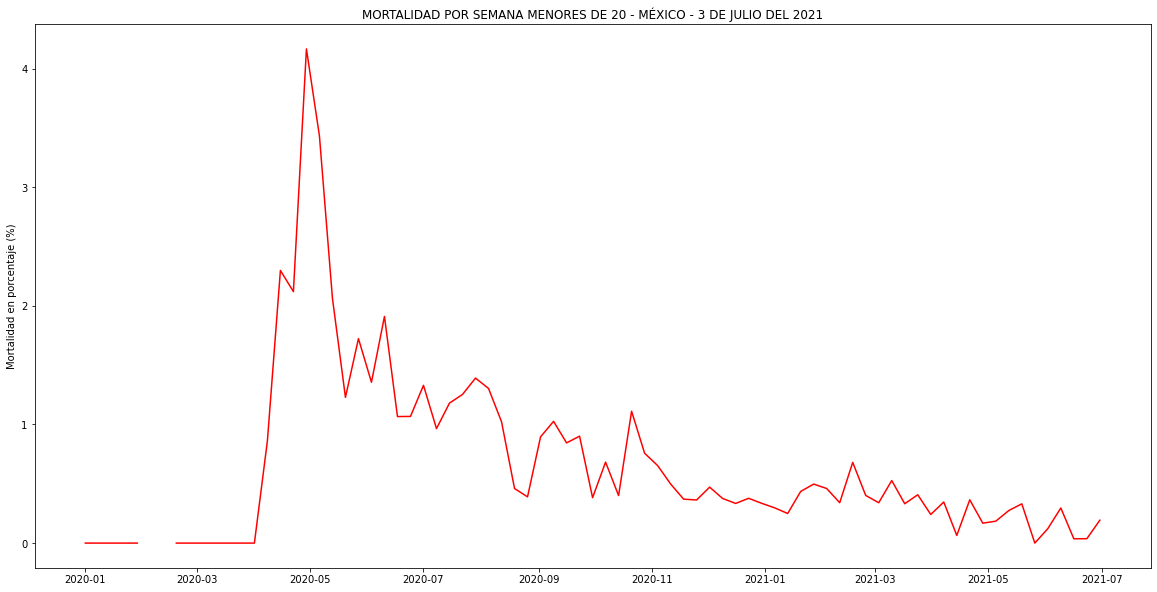

In [172]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA MENORES DE 20 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [173]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

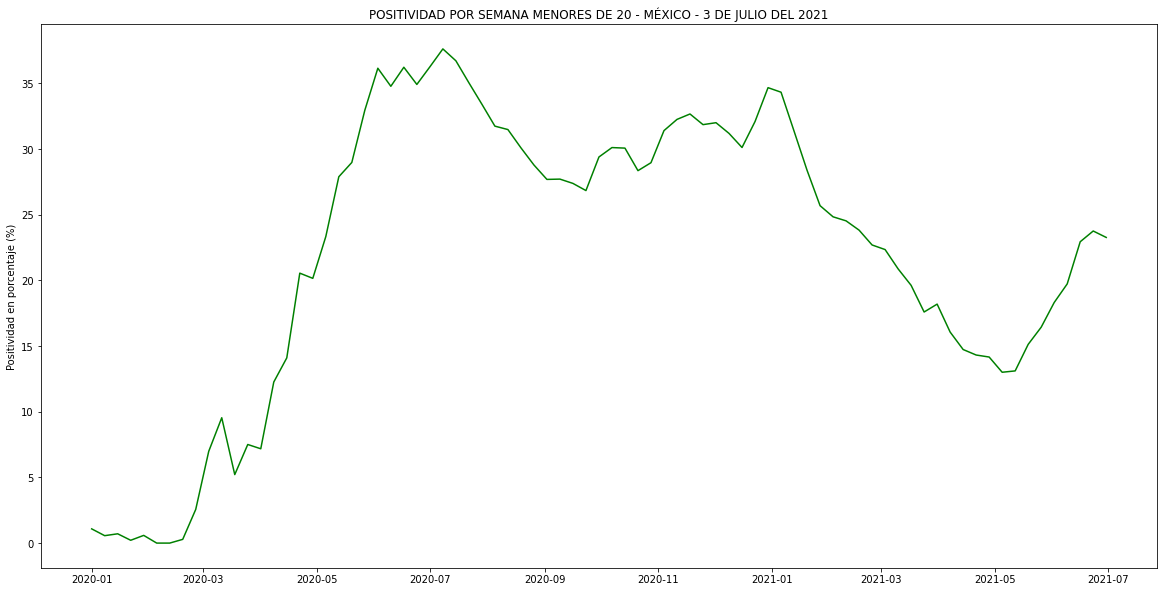

In [174]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA MENORES DE 20 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")